# 🔀 Conditional Agent Workflows with Azure AI Foundry (Python)

## 📋 Advanced Decision-Based Workflow Tutorial

This notebook demonstrates **conditional workflow patterns** using Azure AI Foundry and the Microsoft Agent Framework. You'll learn how to build intelligent, decision-driven workflows that dynamically route processing based on content analysis, business rules, and AI-powered decision making.

## 🎯 Learning Objectives

### 🧠 **Intelligent Decision Making**
- **Conditional Logic**: Implement dynamic branching based on AI analysis and business rules
- **Content-Aware Routing**: Route workflow paths based on content analysis and classification
- **Adaptive Processing**: Adjust workflow behavior based on real-time conditions and data
- **Azure AI Integration**: Leverage Azure AI Foundry's advanced capabilities for decision making

### 🔀 **Advanced Workflow Patterns**
- **Decision Trees**: Build complex decision structures with multiple branching points
- **Rule-Based Processing**: Implement business logic and compliance requirements
- **Dynamic Workflow Modification**: Adapt workflows based on runtime conditions
- **Context-Aware Operations**: Make decisions based on accumulated workflow context

### 🏢 **Enterprise Conditional Applications**
- **Document Classification**: Route documents to appropriate processing workflows
- **Customer Service Triage**: Automatically route inquiries to specialized handling workflows
- **Compliance Processing**: Apply different validation rules based on content type and regulations
- **Quality Assurance**: Route content through different review processes based on quality metrics

## ⚙️ Prerequisites & Setup

### 📦 **Installation & Dependencies**

This workflow requires specific installation steps for Azure AI Foundry integration:

```bash
# Clean installation to avoid conflicts
pip uninstall agent-framework -y
pip uninstall agent-framework-azure-ai -y

# Install latest version with Azure AI Foundry support
pip install -r ../../../Installation/requirements.txt --constraint ../../../Installation/constraints.txt -U
```

### 🔑 **Azure AI Foundry Configuration**

**Required Azure Resources:**
- Azure AI Foundry workspace with appropriate models deployed
- Azure subscription with necessary permissions
- Azure CLI authentication configured


**Authentication Setup:**
```bash
# Azure CLI authentication
az login
az account set --subscription "your-subscription-id"
azd auth login
```

### 🏗️ **Conditional Workflow Architecture**

```mermaid
graph TD
    A[Input Document/Request] --> B[Initial Analysis Agent]
    B --> C{Decision Point}
    C -->|Condition 1| D[Workflow Path A]
    C -->|Condition 2| E[Workflow Path B]
    C -->|Condition 3| F[Workflow Path C]
    D --> G[Specialized Processing A]
    E --> H[Specialized Processing B]
    F --> I[Specialized Processing C]
    G --> J[Result Integration]
    H --> J
    I --> J
    J --> K[Final Output]
```

**Key Components:**
- **Analysis Agents**: AI agents that evaluate content and make routing decisions
- **Decision Points**: Conditional logic that determines workflow paths
- **Specialized Processors**: Different agents optimized for specific content types or scenarios
- **Integration Layer**: Combines results from different workflow paths

## 🎨 **Conditional Workflow Design Patterns**

### 📋 **Document Processing Triage**
```
Document Input → Content Analysis → Classification → Specialized Processing Workflow
```

### 🎯 **Customer Service Routing**
```
Customer Inquiry → Intent Analysis → Urgency Assessment → Route to Specialist Team
```

### 🔍 **Quality Assurance Workflow**
```
Content Input → Quality Metrics → Risk Assessment → Appropriate Review Process
```

### 📊 **Business Intelligence Pipeline**
```
Data Input → Source Analysis → Processing Rules → Specialized Analytics Workflow
```

## 🏢 **Enterprise Benefits**

### 🎯 **Intelligent Automation**
- **Smart Routing**: Automatically direct work to the most appropriate processing path
- **Adaptive Behavior**: Workflows that learn and adapt based on patterns and outcomes
- **Business Rule Integration**: Incorporate complex business logic and compliance requirements
- **Context-Aware Processing**: Make decisions based on full workflow context and history

### 📈 **Operational Efficiency**
- **Reduced Manual Intervention**: Automated decision making reduces need for human routing
- **Specialized Processing**: Each workflow path optimized for specific scenarios
- **Resource Optimization**: Efficient allocation of processing resources based on content type
- **Faster Time-to-Resolution**: Direct routing to appropriate specialists and processes

### 🛡️ **Governance & Control**
- **Audit Trails**: Complete logging of decision points and routing rationale
- **Compliance Enforcement**: Automatic application of regulatory and policy requirements
- **Risk Management**: Route high-risk content through enhanced security and review processes
- **Quality Assurance**: Ensure appropriate level of review based on content characteristics

### 📊 **Analytics & Optimization**
- **Decision Analytics**: Track effectiveness of routing decisions and workflow paths
- **Performance Metrics**: Measure efficiency of different workflow branches
- **Continuous Improvement**: Identify optimization opportunities in conditional logic
- **Business Intelligence**: Gain insights into content patterns and processing requirements

Let's build intelligent, decision-driven AI workflows! 🚀

In [1]:
# ! pip uninstall agent-framework -y
# ! pip uninstall agent-framework-azure-ai -y


requirements.txt & constraints.txt - in ./Installation

please copy .env.examples as .env

In [2]:
# ! git config fetch.showForcedUpdates true

In [3]:
# ! pip install -r ../../../Installation/requirements.txt --constraint ../../../Installation/constraints.txt -U

In [4]:
# ! pip install azure-ai-projects -U
# ! pip install azure-ai-agents==1.2.0b4 -U
# ! pip install pydantic -U
# ! pip install azure-identity

**Note** choose gpt-4.1-mini

In [5]:
import os

from dataclasses import dataclass
from typing_extensions import Literal
from pydantic import BaseModel

In [6]:
from azure.identity.aio import AzureCliCredential
from dotenv import load_dotenv

from agent_framework import HostedWebSearchTool
from agent_framework.azure import AzureAIAgentClient
from agent_framework import (
    AgentExecutor,
    AgentExecutorRequest,
    AgentExecutorResponse,
    HostedCodeInterpreterTool,
    ChatMessage,
    Role,
    WorkflowBuilder,
    WorkflowContext,
    WorkflowEvent,
    executor,
    WorkflowViz
)


from azure.ai.agents.models import BingGroundingTool,CodeInterpreterTool

In [7]:
load_dotenv()

True

In [8]:
EvangelistInstructions = """
You are a technology evangelist create a first draft for a technical tutorials.
1. Each knowledge point in the outline must include a link. Follow the link to access the content related to the knowledge point in the outline. Expand on that content.
2. Each knowledge point must be explained in detail.
3. Rewrite the content according to the entry requirements, including the title, outline, and corresponding content. It is not necessary to follow the outline in full order.
4. The content must be more than 200 words.
4. Output draft as Markdown format. set 'draft_content' to the draft content.
5. return result as JSON with fields 'draft_content' (string).
"""

ContentReviewerInstructions = """
You are a content reviewer for a publishing company. You need to check whether the tutorial's draft content meets the following requirements:

1. The draft content less than 200 words, set 'review_result' to 'No' and 'reason' to 'Content is too short'. If the draft content is more than 200 words, set 'review_result' to 'Yes' and 'reason' to 'The content is good'.
2. set 'draft_content' to the original draft content.
3. return result as JSON with fields 'review_result' (one of Yes, No) and 'reason' (string) and 'draft_content' (string).

"""

PublisherInstructions = """
You are the content publisher ,run code to save the tutorial's draft content as a Markdown file. Saved file's name is marked with current date and time, such as yearmonthdayhourminsec. Note that if it is 1-9, you need to add 0, such as  20240101123045.md. 
"""

In [9]:
OUTLINE_Content ="""
# Introduce AI Agent


## What's AI Agent

https://github.com/microsoft/ai-agents-for-beginners/tree/main/01-intro-to-ai-agents


***Note*** Don's create any sample code 


## Introduce Azure AI Foundry Agent Service 

https://learn.microsoft.com/en-us/azure/ai-foundry/agents/overview


***Note*** Don's create any sample code 


## Microsoft Agent Framework 

https://github.com/microsoft/agent-framework/tree/main/docs/docs-templates


***Note*** Don's create any sample code 
"""

In [10]:
conn_id = os.environ["BING_CONNECTION_ID"]  # Ensure the BING_CONNECTION_NAME environment variable is set

# Initialize the Bing Grounding tool
bing = BingGroundingTool(connection_id=conn_id)

code_interpreter = CodeInterpreterTool()

In [11]:
class EvangelistAgent(BaseModel):
    draft_content: str

class ReviewAgent(BaseModel):
    review_result: Literal["Yes", "No"]
    reason: str
    draft_content: str

class PublisherAgent(BaseModel):
    file_path: str

@dataclass
class ReviewResult:
    review_result: str
    reason: str
    draft_content: str

@executor(id="to_reviewer_result")
async def to_reviewer_result(response: AgentExecutorResponse, ctx: WorkflowContext[ReviewResult]) -> None:

    print(f"Raw response from reviewer agent: {response.agent_run_response.text}")

    parsed = ReviewAgent.model_validate_json(response.agent_run_response.text)
    await ctx.send_message(
        ReviewResult(
            review_result=parsed.review_result,
            reason=parsed.reason,
            draft_content=parsed.draft_content,
        )
    )


def select_targets(review: ReviewResult, target_ids: list[str]) -> list[str]:
        # Order: [handle_review, submit_to_email_assistant, summarize_email, handle_uncertain]
        handle_review_id, save_draft_id = target_ids
        if review.review_result == "Yes":
            return [save_draft_id]
        else:
            return [handle_review_id]
        


@executor(id="handle_review")
async def handle_review(review: ReviewResult, ctx: WorkflowContext[str]) -> None:
    if review.review_result == "No":
        await ctx.yield_output(f"Review failed: {review.reason}, please revise the draft.")
    else:
        await ctx.send_message(
            AgentExecutorRequest(messages=[ChatMessage(Role.USER, text=review.draft_content)], should_respond=True)
        )


@executor(id="save_draft")
async def save_draft(review: ReviewResult, ctx: WorkflowContext[AgentExecutorRequest]) -> None:
    # Only called for long NotSpam emails by selection_func
    await ctx.send_message(
        AgentExecutorRequest(messages=[ChatMessage(Role.USER, text=review.draft_content)], should_respond=True)
    )


In [12]:
from IPython.display import SVG, display, HTML

In [13]:
class DatabaseEvent(WorkflowEvent): ...

Generating workflow visualization...
Mermaid string: 
flowchart TD
  evangelist_agent["evangelist_agent (Start)"];
  reviewer_agent["reviewer_agent"];
  to_reviewer_result["to_reviewer_result"];
  handle_review["handle_review"];
  save_draft["save_draft"];
  publisher_agent["publisher_agent"];
  evangelist_agent --> reviewer_agent;
  reviewer_agent --> to_reviewer_result;
  to_reviewer_result --> handle_review;
  to_reviewer_result --> save_draft;
  save_draft --> publisher_agent;
DiGraph string: 
digraph Workflow {
  rankdir=TD;
  node [shape=box, style=filled, fillcolor=lightblue];
  edge [color=black, arrowhead=vee];

  "evangelist_agent" [fillcolor=lightgreen, label="evangelist_agent\n(Start)"];
  "reviewer_agent" [label="reviewer_agent"];
  "to_reviewer_result" [label="to_reviewer_result"];
  "handle_review" [label="handle_review"];
  "save_draft" [label="save_draft"];
  "publisher_agent" [label="publisher_agent"];
  "evangelist_agent" -> "reviewer_agent";
  "reviewer_agent" -> "t

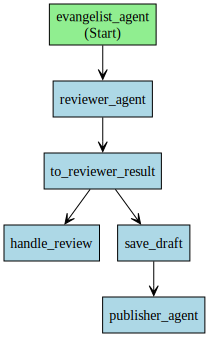

Workflow output: None
Workflow output: None
Workflow output: None
Workflow output: {
  "draft_content": "# Introduction to AI Agents and Microsoft Agent Framework\n\n## What is an AI Agent?\n\nAI Agents are sophisticated systems designed to extend the capabilities of Large Language Models (LLMs) by enabling them to perform actions autonomously or semiautonomously within defined environments. Unlike simple AI assistants, AI Agents operate as integrated systems composed of multiple components, including sensors to perceive the environment, actuators to effect change, and of course, the underlying LLM that powers reasoning and language understanding. These components work together within a specific environment - for example, a travel booking system - where the agent can retrieve real-time information, analyze the data, make decisions, and execute actions such as booking a hotel room for a user.\n\nThe power of AI Agents lies in their autonomy and ability to access external tools and knowl

In [14]:
async with (
        AzureCliCredential() as credential,
        AzureAIAgentClient(async_credential=credential) as chat_client,
    ):  
        try:
                evangelist_agent = AgentExecutor(chat_client.create_agent(
                    instructions= (EvangelistInstructions),
                    tools=[HostedWebSearchTool()],
                    # response_format=EvangelistAgent
                ),  id="evangelist_agent")
                reviewer_agent = AgentExecutor(chat_client.create_agent(
                    instructions=(ContentReviewerInstructions),
                    # response_format=ReviewAgent
                ), id="reviewer_agent")
                publisher_agent = AgentExecutor(chat_client.create_agent(
                    instructions=PublisherInstructions,
                    tools=HostedCodeInterpreterTool(),
                    response_format=PublisherAgent
                ), id="publisher_agent")

                workflow = (
                    WorkflowBuilder()
                        .set_start_executor(evangelist_agent)
                        .add_edge(evangelist_agent, reviewer_agent)
                        .add_edge(reviewer_agent, to_reviewer_result)
                        .add_multi_selection_edge_group(
                            to_reviewer_result,
                            [handle_review, save_draft],
                            selection_func=select_targets,
                        )
                        .add_edge(save_draft, publisher_agent)
                        .build()
                )

                # workflow = SequentialBuilder().participants([evangelist_chat_agent, reviewer_chat_agent, publisher_chat_agent]).build()
                print("Generating workflow visualization...")
                viz = WorkflowViz(workflow)
                # Print out the mermaid string.
                print("Mermaid string: \n=======")
                print(viz.to_mermaid())
                print("=======")
                # Print out the DiGraph string.
                print("DiGraph string: \n=======")
                print(viz.to_digraph())
                print("=======")
                svg_file = viz.export(format="svg")
                print(f"SVG file saved to: {svg_file}")

                if svg_file and os.path.exists(svg_file):
                    try:
                        # Preferred: direct SVG rendering
                        display(SVG(filename=svg_file))
                    except Exception as e:
                        print(f"⚠️ Direct SVG render failed: {e}. Falling back to raw HTML.")
                        try:
                            with open(svg_file, "r", encoding="utf-8") as f:
                                svg_text = f.read()
                            display(HTML(svg_text))
                        except Exception as inner:
                            print(f"❌ Fallback HTML render also failed: {inner}")
                else:
                    print("❌ SVG file not found. Ensure viz.export(format='svg') ran successfully.")

                
                task = """
                    You are a evangelist , need to write a  draft based on the following outline and the content provided in the link corresponding to the outline. After draft create , the reviewer check it , if it meets the requirements, it will be submitted to the publisher and save it as a Markdown file, otherwise need to rewrite draft until it meets the requirements.
                        The provided outline content and related links is as follows:

                    """ + OUTLINE_Content

                
                async for event in workflow.run_stream(task):
                    if isinstance(event, DatabaseEvent):
                        print(f"{event}")
                    if isinstance(event, WorkflowEvent):
                        print(f"Workflow output: {event.data}")



        finally:
            print("done")
